In [2]:
import os
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from omegaconf import OmegaConf

import warnings
warnings.filterwarnings("ignore")

# 디렉토리 설정
os.chdir('/Volume/VAD/LifeLongerAD_pilot')
def filter_rows(row):
    seen_gt_classes = set()
    class_name = row['class_name']
    gt_class_name = row['GT_class_name']
    if gt_class_name not in seen_gt_classes:
        seen_gt_classes.add(gt_class_name)
    return class_name in seen_gt_classes

log_dirs = glob('/Volume/VAD/LifeLongerAD_pilot/results/*/MVTecAD/*/*/')
df = pd.DataFrame()

for log_dir in log_dirs:
    config = OmegaConf.load(os.path.join(log_dir, 'configs.yaml'))
    config = {
        'continual': config.CONTINUAL.continual,
        'online': config.CONTINUAL.online,
        'continual_method': config.CONTINUAL.method.name,
        'Model': config.MODEL.method
    }
    result = pd.read_csv(os.path.join(log_dir, 'result.csv')).drop(columns=['epoch_time', 'task'])

    for key in config.keys():
        result[key] = config[key]
        
    result[result.apply(filter_rows,axis=1)].reset_index(drop=True)

    df = pd.concat([df, result])
    
df = df[(df['continual'] == True) & 
        (df['last']==1)
        ].drop(columns='continual').reset_index(drop=True)

class_order = [
    'grid', 'carpet', 'cable', 'zipper', 'wood', 'tile', 'metal_nut', 'transistor', 
    'bottle', 'leather', 'pill', 'hazelnut', 'toothbrush', 'capsule', 'screw'
]
df.loc[df['continual_method']=='EMPTY','continual_method'] = 'None'

In [227]:
result = pd.DataFrame()
for online in df['online'].unique():
    for m in df['Model'].unique():
        for cm in df['continual_method'].unique():
            seen_gt_classes = set()            
            subset = df[
                (df['online']==online) &
                (df['Model']==m) &
                (df['continual_method']==cm)
            ]
            for cn in subset['GT_class_name'].unique():
                temp = subset[subset['GT_class_name']==cn]
                temp = temp.iloc[:-1] if cn != 'screw' else temp 
                
                temp = pd.DataFrame(subset[subset['GT_class_name']==cn].mean()).T
                
                temp['GT_class_name'] = cn 
                temp['Model'] = m 
                temp['continual_method'] = cm 
                temp['online'] = online 
                
                result = pd.concat([result,temp])
                
df = result.reset_index(drop=True)            

In [228]:
df

,epoch,img_level_auroc,img_level_average_precision,pix_level_auroc,pix_level_average_precision,last,online,GT_class_name,Model,continual_method
0,99.0,0.982146,0.994875,0.985148,0.443760,1.0,False,grid,ReverseDistillation,EWC
1,99.0,0.736228,0.836741,0.691738,0.188955,1.0,False,carpet,ReverseDistillation,EWC
2,99.0,0.628415,0.826470,0.696275,0.153057,1.0,False,cable,ReverseDistillation,EWC
3,99.0,0.768534,0.898558,0.745231,0.182020,1.0,False,zipper,ReverseDistillation,EWC
4,99.0,0.756678,0.881522,0.757997,0.200203,1.0,False,wood,ReverseDistillation,EWC
...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.571462,0.760103,0.486655,0.132724,1.0,True,pill,FastFlow,None
116,0.0,0.559617,0.770862,0.473487,0.113602,1.0,True,hazelnut,FastFlow,None
117,0.0,0.516431,0.745916,0.427535,0.093494,1.0,True,toothbrush,FastFlow,None
118,0.0,0.504845,0.739222,0.448531,0.078826,1.0,True,capsule,FastFlow,None


In [232]:
# Add a column for ordering
category_dtype = pd.CategoricalDtype(categories=class_order, ordered=True)
df['GT_class_name'] = df['GT_class_name'].astype(category_dtype)
df = df.melt(['epoch','last','online','GT_class_name','Model','continual_method']).reset_index(drop=True)

# Offline 

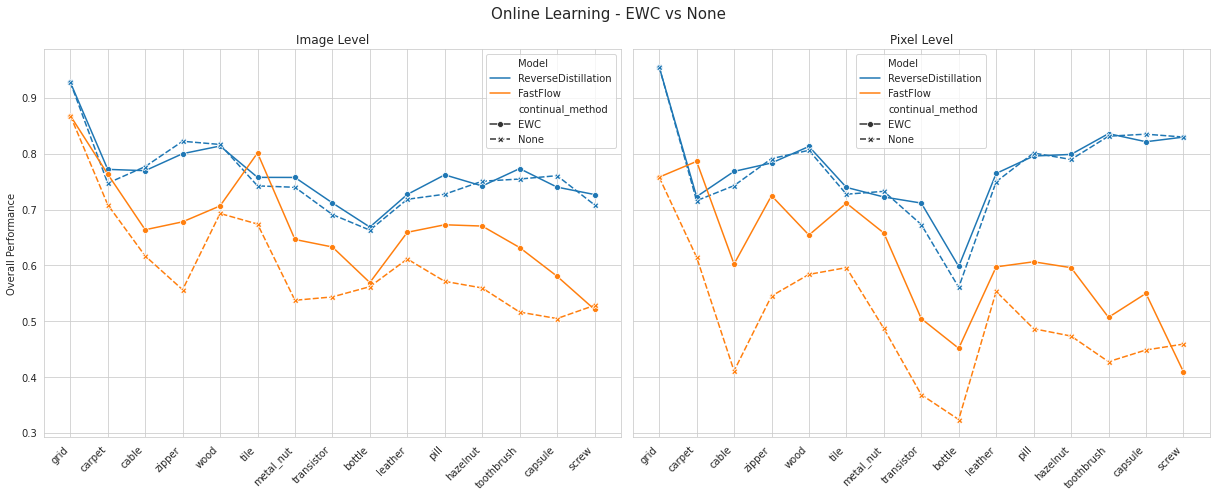

In [241]:
# Create the subplots
fig, axes = plt.subplots(1,2, figsize=(17, 7), sharey=True)
axes = axes.flatten()

# Iterate through each class_name
for i, metric in enumerate(['img_level_auroc','pix_level_auroc']):
    ax = axes[i]
    subset = df[(df['variable']==metric) & (df['online']==True)]
    
    if not subset.empty:
        sns.lineplot(
            ax=ax,
            data=subset,
            x='GT_class_name',
            y='value',
            hue='Model',
            style='continual_method',
            markers=True
        )
        title = 'Image Level' if metric == 'img_level_auroc' else "Pixel Level"
        ax.set_title(title)
        ax.set_xlabel('')
        ax.set_ylabel('Overall Performance')
        ax.set_xticks(range(len(class_order)))
        ax.set_xticklabels(class_order, rotation=45, ha='right')

# Hide any unused axes
for j in range(len(class_order), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.suptitle('Online Learning - EWC vs None',fontsize=15)
plt.tight_layout()
plt.show()

# Online 

In [75]:
import os
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings("ignore")

# 디렉토리 설정
os.chdir('/Volume/VAD/LifeLongerAD_pilot')
def filter_rows(row):
    seen_gt_classes = set()
    class_name = row['class_name']
    gt_class_name = row['GT_class_name']
    if gt_class_name not in seen_gt_classes:
        seen_gt_classes.add(gt_class_name)
    return class_name in seen_gt_classes

log_dirs = glob('/Volume/VAD/LifeLongerAD_pilot/results/*/MVTecAD/*/*/')
df = pd.DataFrame()

for log_dir in log_dirs:
    config = OmegaConf.load(os.path.join(log_dir, 'configs.yaml'))
    config = {
        'continual': config.CONTINUAL.continual,
        'online': config.CONTINUAL.online,
        'continual_method': config.CONTINUAL.method.name,
        'Model': config.MODEL.method
    }
    result = pd.read_csv(os.path.join(log_dir, 'result.csv')).drop(columns=['epoch_time', 'task'])

    for key in config.keys():
        result[key] = config[key]
        
    result[result.apply(filter_rows,axis=1)].reset_index(drop=True)

    df = pd.concat([df, result])
    
df = df[
    (df['continual']==True) &
    (df['last']==1)
].reset_index(drop=True).drop(columns='continual')


result = pd.DataFrame()
for online in df['online'].unique():
    for m in df['Model'].unique():
        for cm in df['continual_method'].unique():
            seen_gt_classes = set()
            temp = df[
                    (df['Model']==m) & 
                    (df['continual_method']==cm) & 
                    (df['online']==online)
                    ].reset_index(drop=True)
            # temp = temp[temp.apply(filter_rows,axis=1)]
        
            result = pd.concat([result,temp])
df = result.reset_index(drop=True)

category_dtype = pd.CategoricalDtype(categories=class_order, ordered=True)
df['GT_class_name'] = df['GT_class_name'].astype(category_dtype)

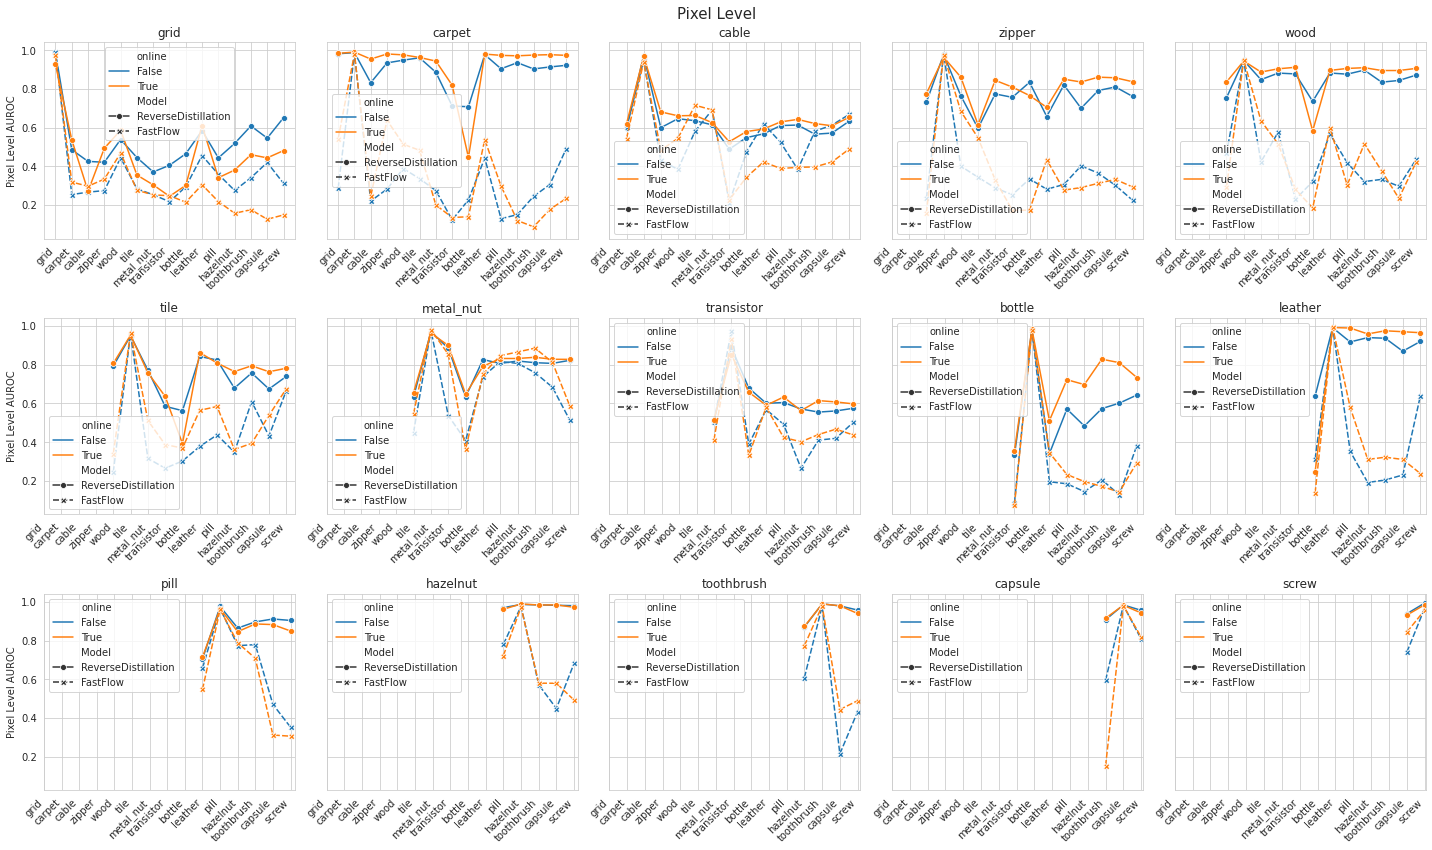

In [81]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharey=True)
axes = axes.flatten()

# Iterate through each class_name
for i, class_name in enumerate(class_order):
    ax = axes[i]
    seen_gt_classes = set()
    subset = df[(df['class_name'] == class_name) &
                (df['continual_method'] == 'EMPTY')]
    subset[subset.apply(filter_rows,axis=1)].reset_index(drop=True)
    if not subset.empty:
        sns.lineplot(
            ax=ax,
            data=subset,
            x='GT_class_name',
            y='pix_level_auroc',
            hue='online',
            style='Model',
            markers=True
        )
        ax.set_title(class_name)
        ax.set_xlabel('')
        ax.set_ylabel('Pixel Level AUROC')
        ax.set_xticks(range(len(class_order)))
        ax.set_xticklabels(class_order, rotation=45, ha='right')

# Hide any unused axes
for j in range(len(class_order), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.suptitle('Pixel Level',fontsize=15)
plt.tight_layout()
plt.show()

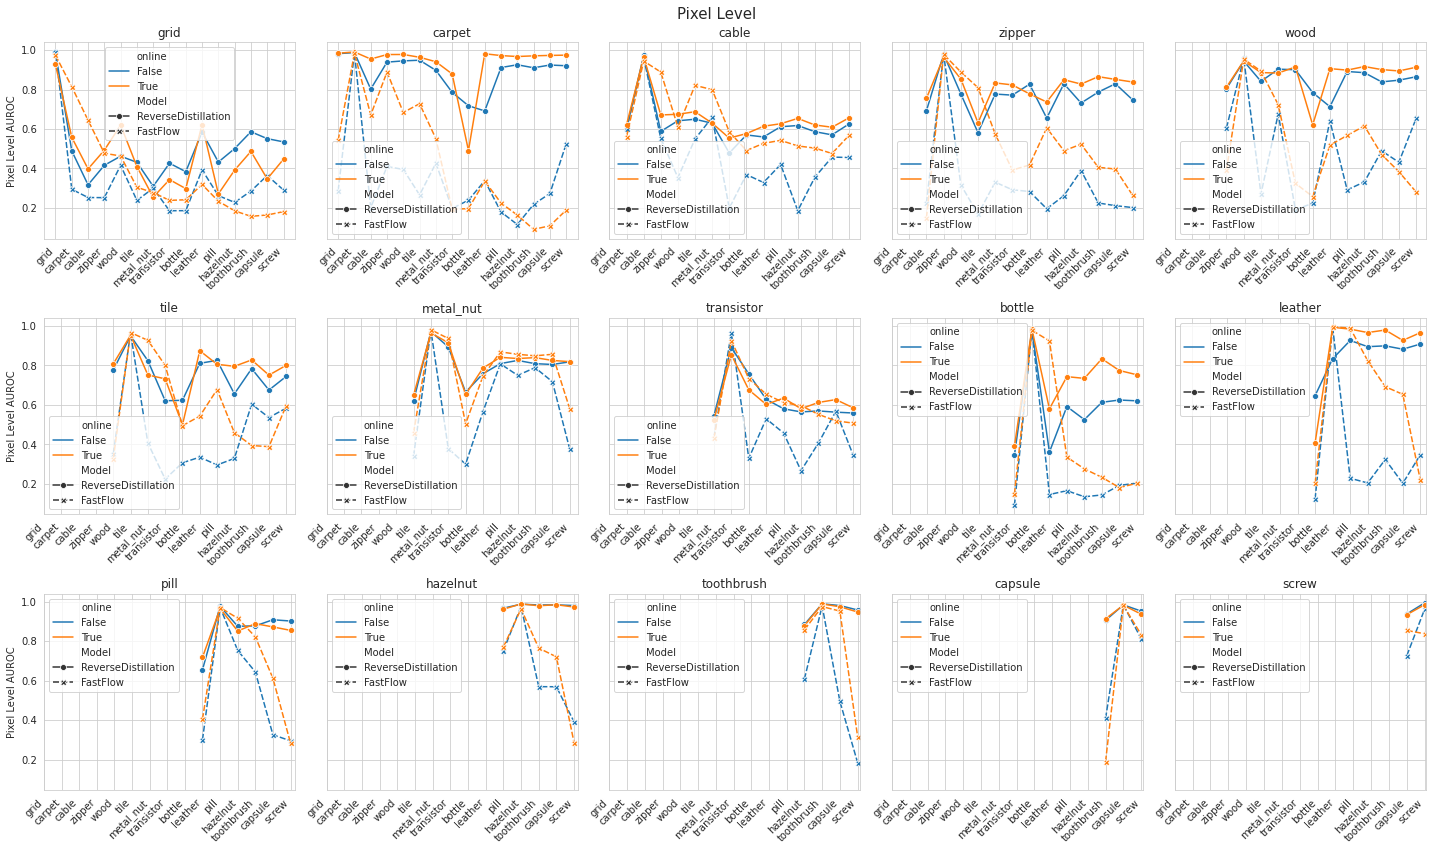

In [82]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharey=True)
axes = axes.flatten()

# Iterate through each class_name
for i, class_name in enumerate(class_order):
    ax = axes[i]
    seen_gt_classes = set()
    subset = df[(df['class_name'] == class_name) &
                (df['continual_method'] == 'EWC')]
    subset[subset.apply(filter_rows,axis=1)].reset_index(drop=True)
    if not subset.empty:
        sns.lineplot(
            ax=ax,
            data=subset,
            x='GT_class_name',
            y='pix_level_auroc',
            hue='online',
            style='Model',
            markers=True
        )
        ax.set_title(class_name)
        ax.set_xlabel('')
        ax.set_ylabel('Pixel Level AUROC')
        ax.set_xticks(range(len(class_order)))
        ax.set_xticklabels(class_order, rotation=45, ha='right')

# Hide any unused axes
for j in range(len(class_order), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.suptitle('Pixel Level',fontsize=15)
plt.tight_layout()
plt.show()

# Gradient 

In [3]:
grad_dirs = glob('/Volume/VAD/LifeLongerAD_pilot/results/ReverseDistillation/MVTecAD/baseline_EMPTY-Continual_True-online_True/seed_0/gradients/*')
def ensure_dim(vec):
    if len(vec.shape) == 1:
        vec = np.expand_dims(vec, axis=1)
    elif vec.shape[-1] == 1:
        vec = vec.squeeze(-1)
    return vec

def cosine_similarity_efficient(vec1, vec2):
    # Ensure correct dimensions
    vec1 = ensure_dim(vec1)
    vec2 = ensure_dim(vec2)

    # Debug shapes

    # Calculate dot product
    dot_product = np.sum(vec1 * vec2, axis=1)

    # Calculate norms
    norm_vec1 = np.sqrt(np.sum(vec1**2, axis=1))
    norm_vec2 = np.sqrt(np.sum(vec2**2, axis=1))

    # Avoid division by zero
    eps = 1e-8
    similarity = dot_product / (norm_vec1 * norm_vec2 + eps)
    
    return similarity



grad_sim = [] 
for gd in grad_dirs:
    gradients = np.load(gd, allow_pickle=True)
    for i in range(len(gradients) - 1):  # i+1 인덱스 방지
        i_grad = list(gradients[i].values())
        for j in range(len(i_grad)):
            vec1 = i_grad[j]
            vec2 = list(gradients[i+1].values())[j]
            try:
                similarity = cosine_similarity_efficient(vec1, vec2)
                grad_sim.append(similarity.mean())
            except ValueError as e:
                print(f"Error with vectors at i={i}, j={j}: {e}")


In [3]:
import os
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from omegaconf import OmegaConf

import warnings
warnings.filterwarnings("ignore")

# 디렉토리 설정
os.chdir('/Volume/VAD/LifeLongerAD_pilot')
def filter_rows(row):
    seen_gt_classes = set()
    class_name = row['class_name']
    gt_class_name = row['GT_class_name']
    if gt_class_name not in seen_gt_classes:
        seen_gt_classes.add(gt_class_name)
    return class_name in seen_gt_classes

log_dirs = glob('/Volume/VAD/LifeLongerAD_pilot/results/*/MVTecAD/*/*/')
df = pd.DataFrame()

for log_dir in log_dirs:
    config = OmegaConf.load(os.path.join(log_dir, 'configs.yaml'))
    config = {
        'continual': config.CONTINUAL.continual,
        'online': config.CONTINUAL.online,
        'continual_method': config.CONTINUAL.method.name,
        'Model': config.MODEL.method
    }
    

In [6]:
file_paths = sorted(glob('/Volume/VAD/LifeLongerAD_pilot/results/ReverseDistillation/MVTecAD/baseline_*-Continual_*-online_*/seed_0/gradients/*'))
sorted_file_paths = sorted(file_paths, key=lambda x: class_order.index(
    next((cls for cls in class_order if cls in x), None)
))

In [16]:
from tqdm import tqdm 
class_order = [
    'grid', 'carpet', 'cable', 'zipper', 'wood', 'tile', 'metal_nut', 'transistor', 
    'bottle', 'leather', 'pill', 'hazelnut', 'toothbrush', 'capsule', 'screw'
]
def ensure_dim(vec):
    if len(vec.shape) == 1:
        vec = np.expand_dims(vec, axis=1)
    elif vec.shape[-1] == 1:
        vec = vec.squeeze(-1)
    return vec

def cosine_similarity_efficient(vec1, vec2):
    # Ensure correct dimensions
    vec1 = ensure_dim(vec1)
    vec2 = ensure_dim(vec2)

    # Debug shapes

    # Calculate dot product
    dot_product = np.sum(vec1 * vec2, axis=1)

    # Calculate norms
    norm_vec1 = np.sqrt(np.sum(vec1**2, axis=1))
    norm_vec2 = np.sqrt(np.sum(vec2**2, axis=1))

    # Avoid division by zero
    eps = 1e-8
    similarity = dot_product / (norm_vec1 * norm_vec2 + eps)
    
    return similarity


exp_list = glob('/Volume/VAD/LifeLongerAD_pilot/results/*/MVTecAD/*')
results = {} 

results['Draem']=[]
results['ReverseDistillation']=[]
results['FastFlow']=[]

for exp in exp_list:
    file_paths = sorted(glob(f'{exp}/seed_0/gradients/*'))
    sorted_file_paths = sorted(file_paths, key=lambda x: class_order.index(
        next((cls for cls in class_order if cls in x), None)
    ))
    model_name, exp_name = np.array(exp.split('/'))[[5,7]]
    
    grad_sim = [] 
    for gd in tqdm(sorted_file_paths):
        gradients = np.load(gd, allow_pickle=True)
        for i in range(len(gradients) - 1):  # i+1 인덱스 방지
            i_grad = list(gradients[i].values())
            for j in range(len(i_grad)):
                vec1 = i_grad[j]
                vec2 = list(gradients[i+1].values())[j]
                try:
                    similarity = cosine_similarity_efficient(vec1, vec2)
                    grad_sim.append(similarity.mean())
                except ValueError as e:
                    print(f"Error with vectors at i={i}, j={j}: {e}")

    results[model_name].append({exp_name:grad_sim})

100%|██████████| 300/300 [03:03<00:00,  1.64it/s]


In [4]:
import pickle  
with open('data.pkl','rb') as f:
    results = pickle.load(f)

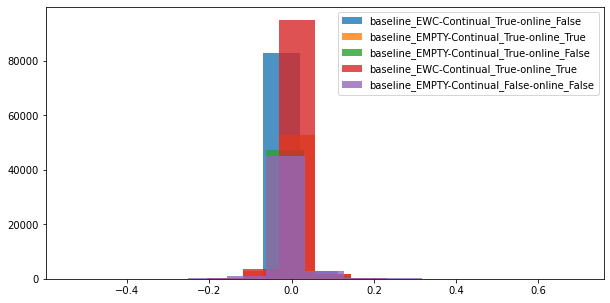

In [24]:
plt.figure(figsize=(10,5))
for r in results['ReverseDistillation']:
    name = list(r.keys())[0]
    if '' in name:
        plt.hist(list(r.values()),bins=13,label=name,alpha=0.8)
plt.legend()
plt.show()

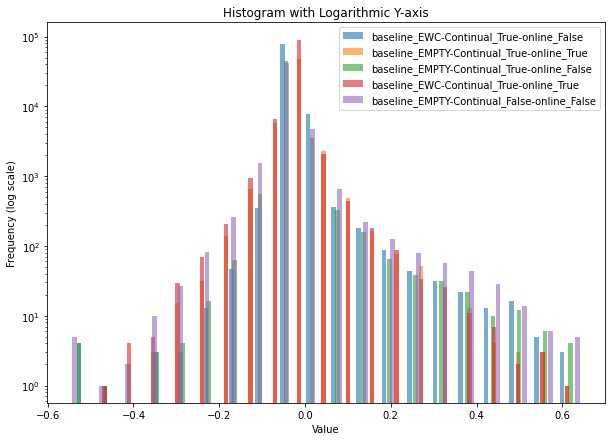

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

# 막대 간격 조정
num_results = len(results['ReverseDistillation'])  # 막대 그룹 개수
bin_width = 0.9

for i, r in enumerate(results['ReverseDistillation']):
    data = list(r.values())
    label = list(r.keys())[0]
    
    # 히스토그램 생성
    bins = np.histogram_bin_edges(data, bins=20)
    plt.hist(data, bins=bins, alpha=0.6, label=label, rwidth=bin_width / num_results, 
             align='left', histtype='bar', stacked=False)

# y축 로그 스케일 적용
plt.yscale('log')
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram with Logarithmic Y-axis")
plt.show()
